1. 
First need to read in the weekly returns for the 9 specified stocks from the period Jan 2005 - Dec 2009.
Stocks are Wells Fargo, JP Morgan, Apple, Microsoft, Google, IBM, Walmart, AIG, and GE.

In [15]:
#Need to run this command at anaconda prompt: "$ pip3 install yfinance"
import arch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import yfinance as yf


In [79]:
#spx is the sp500
data = yf.download(
        tickers = 'wfc jpm aapl msft googl ibm wmt aig ge spy', 
        start = "2005-01-01", 
        end = "2008-12-31",
        interval = "1wk",
        group_by = 'ticker',
        threads = True)

[*********************100%***********************]  10 of 10 completed


Now lets turn this multi-index df into a regular df and looking only at AdjClose which we'll use to calculate 
the logreturn values weekly. Also, periodic NA values result from yfinance throwing in random non week ending datapoints, probably resulting from choosing Jan 1st 2005 as the starting point which was a Saturday. So, lets drop those and then calculate log returns. $$ \textbf{Beware, running this cell twice kills the structure, so if you do, you need to run the yf.download cell again before moving on.} $$

In [80]:
AdjClose = data.iloc[:, data.columns.get_level_values(1) == 'Adj Close']
processed = AdjClose.dropna()
processed.columns = processed.columns.droplevel(1)  #turns columns from multi-index to normal index
logRet = np.log(processed)
logRet = logRet.diff()
logRet = logRet.dropna()
logRet.head(25)

,GE,WMT,SPY,AAPL,MSFT,WFC,JPM,IBM,GOOGL,AIG
Date,,,,,,,,,,
2005-01-08,-0.013423,0.000000,-0.001690,0.013625,-0.020838,-0.024094,-0.006761,-0.017696,0.031083,-0.021538
2005-01-15,-0.011041,-0.018318,-0.012425,0.004123,-0.018157,-0.009436,-0.025718,-0.018448,-0.060237,-0.000303
2005-01-22,0.017495,-0.011002,0.005551,0.048323,0.020452,0.006631,0.004063,0.005505,0.010882,-0.003940
2005-01-29,0.013889,0.019455,0.023564,0.063626,0.005333,0.007572,0.018477,0.017290,0.071071,0.024893
2005-02-05,-0.000552,-0.025769,0.004481,0.029619,-0.013387,-0.003416,-0.005587,-0.012885,-0.086638,0.079677
2005-02-12,-0.009707,0.011830,-0.003151,0.066684,-0.019049,-0.008159,-0.026221,0.001584,0.054769,-0.059010
2005-02-19,-0.007273,-0.023608,0.008601,0.024802,-0.005987,0.001504,0.012521,-0.005052,-0.062967,-0.008450
2005-02-26,0.020196,0.030789,0.010649,-0.038604,-0.003173,0.009967,0.014500,-0.004644,0.000161,-0.048717
2005-03-05,-0.008340,-0.028655,-0.019250,-0.061166,-0.003183,-0.011638,-0.038038,-0.009354,-0.044550,-0.004129


2. 
Conduct the NPEB analysis on the individual returns in order to generate the return distribution as well as the covariance relationships.



and via the text, we know that $\mu_{n}$ and $\textbf{V}_{n}$ are 

$$ \mu_{n} = (\hat{\beta}_{1}^{T} x_{1,n-1}, ... , \hat{\beta}_{m}^{T} x_{m,n-1} )^{T} $$

$$ \textbf{V}_{n} = \textbf{\mu}_{n} \textbf{\mu}_{n}^{T} + (\hat{s}_{i,n} \hat{s}_{j,n} \hat{\sigma}_{i,j}) $$

Then, search for $\eta$ by minimizing (2.11) for given $\lambda$, followed by searching for $\lambda$ over a grid to minimize (maximize right?) the information ratio: 
$$E_{\mu, \Sigma} (w_{\lambda}^{T} r - r_{b}) / \sqrt{(Var_{\mu, \Sigma} (w_{\lambda}^{T} r - r_{b})} $$

In [ ]:
#Lets first find the prior distribution via MLE estimators (practice of NPEB). 
#First, we can model the return at time t as Linear Regression with Garch errors


X = logRet.shift(1) #we'll be using prevoius observations
risk_lambda = [2**i for i in range(-3,7)]
numAssets = 9
onePerReturn = []
windowSize = 120
rescale = 100


s_prev = np.zeros((len(logRet), numAssets))


for time, i in enumerate(range(100, len(logRet))):
    mu_n = np.zeros(numAssets)
    V_n = np.ones((numAssets, numAssets))
    z_t = np.ones(numAssets)
    
    iterator = 0

    for col in logRet.columns:
        if col == 'SPY':
            continue
        leftIndex = max(0, i - windowSize)
        col_1 = X.columns.get_loc('SPY')
        col_2 = X.columns.get_loc(col)
        exog = X.iloc[1:i, [col_1, col_2]]
        y = logRet.iloc[1:i, logRet.columns == col].to_numpy().flatten()
        
        
        #Rescale y? How does that change parameter values
        y = y * rescale

        model = arch.arch_model(y, x = exog, mean = 'ARX', dist = 't')
        res = model.fit(disp = "off")
        
        data = np.array([1,X.iloc[i, col_1], X.iloc[i, col_2]])
        #Calculate mu_n, partially V_n for optimal Weight Portfolio
        #assume that the parameter list has the 'ARX' model parameters first
        
        
        #parmams list as follows: also need to undo rescale for parameters
        Beta_constant = res.params[0] / rescale
        Beta_SPY = res.params[1] / rescale
        Beta_prevReturn = res.params[2] / rescale
        s_omega = res.params[3]
        s_alpha = res.params[4]
        s_beta = res.params[5]
        s_nu = res.params[6]

        
        mu_n[iterator] = np.transpose(np.array([Beta_constant, Beta_SPY, Beta_prevReturn]))@data 
        
        s_i = np.sqrt(s_omega + s_alpha*(s_prev[time,iterator]**2) + \
                      s_beta*(logRet.iloc[time, logRet.columns == col]**2))
        
        s_prev[time, iterator] = s_i
        
        for i in range(0, numAssets):
            V_n[iterator, i] *= s_i
            if iterator != i:
                V_n[i, iterator] *= s_i

        #To get cov(zi, zj), need to divide epsilon by s
        epsilon = logRet.iloc[i, logRet.columns == col] - mu_n[iterator]
        z_t[iterator] = epsilon / s_i
        
        iterator += 1
        
    #Finish calculating V_n, mult by sigma's

    for i in range(0, numAssets):
        for j in range(0, numAssets):
            V_n[i,j] *= z_t[i]*z_t[j]
        
    #Finish calulating V_n, outer product of mu_n
    for idx1, i in enumerate(mu_n):
        for idx2, j in enumerate(mu_n):
            V_n[idx1, idx2] += i*j
            

    #optimalWeights = calcOptPortfolioWeight(mu_n, V_n, risk_lambda)
    #onePerReturn[logRet[i].index] = np.transpose(optimalWeights)@logRet.iloc[i, logRet.columns != 'SPY']
        
    

In [ ]:
#Define function for calculating mu and V


In [18]:
#Define function for calculating optimal weight portfolio and eta for given lambda

def calcOptPortfolioWeight(mu_n, V_n, risk_lambda):
    informationRatio = -1000000 #essentially like -inf
    optWeight = np.ones(mu_n.shape)
    
    
    for lam in risk_lambda
        inverseV_n = np.linalg.inv(V_n)
        ones = np.ones(mu_n.shape[0])
    
        A_n = np.transpose(mu_n)@inverseV_n@ones
        B_n = np.transpose(mu_n)@inverseV_n@mu_n
        C_n = np.transpose(ones)@inverseV_n@ones
    
        assert (B_n - (A_n**2)/C_n)*(B_n - ((A_n**2)/C_n) - 1) < 0
        print("C(eta) has no minimum")
    
        Z1 = (B_n - ((A_n**2)/C_n))*(B_n - ((A_n**2)/C_n) - 1)
        Z2 = ((1/(2.0*lamb)) + (A_n/C_n))*(B_n - ((A_n**2)/C_n))
        eta = -(Z1*2*lam)/Z2
        
        term1 = (1.0/C_n)*inverseV_n@ones 
        term2 = (eta/(2*lam))*inverseV_n@(mu_n - (A_n/C_n)*ones)
        weight = term1 + term2
        newInfoRatio = calcInfoRatio(weight, mu_n, V_n, lam)
        if newInfoRatio > informationRatio:
            optWeight = weight
        
    return optWeight
        
def infoRatio(weight, mu_n, V_n, lam):
    #Need to figure out how to calculate this
    #Is it a boostrap?

5. 
Using these dynamic portfolio weights, model the cumulative returns for the period and compare them to plug-in portfolio.

In [12]:
#Lets first find the plug-in returns using the same idea with a sliding window

def optimalWeight(retMean, retCov, targetReturn, riskFree):
    inverseCov = np.linalg.inv(retCov)
    riskAdjMean = np.subtract(retMean, riskFree)
    one = np.ones((len(retMean),1))
    
    A = np.ndarray.item(np.transpose(riskAdjMean)@inverseCov@one)
    B = np.ndarray.item(np.transpose(riskAdjMean)@inverseCov@riskAdjMean)
    C = np.transpose(one)@inverseCov@one
    D = B*C - A**2

    numerator = B*inverseCov@one - A*inverseCov@riskAdjMean
    numerator += targetReturn*(C*inverseCov@riskAdjMean - A*inverseCov@one)
    optimalWeights = numerator * (1/D)

    return optimalWeights

In [50]:
windowSize = 120
rf = 0
numAssets = 9 
maxRet = 0.01   #This is very conservative, is there some way to enforce no short-selling?

#In order to find the plug-in portfolio that returns the highest information ratio, we'll need to do some
#grid searching

mu = np.linspace(0.1, maxRet, 51)

plugInReturn = []
riskFree = np.full((numAssets,1), rf)


for i in range(10, len(logRet)):   #algo unstable for low history, so we start at n = 10
    leftIndex = max(0, i - windowSize)
    sampleMean = logRet.iloc[leftIndex:i, logRet.columns != 'SPY'].mean(axis = 0)
    sampleCov = logRet.iloc[leftIndex:i, logRet.columns != 'SPY'].cov()
    periodRet = logRet.iloc[i, logRet.columns != 'SPY']
    marketRet = logRet.iloc[i, logRet.columns == 'SPY']
        
    sampleMeanMatrix = sampleMean.to_numpy()
    sampleMeanMatrix = sampleMeanMatrix.reshape((numAssets,1))
    sampleCovMatrix = sampleCov.to_numpy()
    periodRetMatrix = periodRet.to_numpy()
    
    InfoRatio = -10000000  #just need it to be a value that no other value will fail to be a max
    maxWeight = np.ones((numAssets,1))
    
    for j in mu:
        
        optimalweights = optimalWeight(sampleMeanMatrix, sampleCovMatrix, j, riskFree)
        expectedReturn = np.ndarray.item(np.transpose(optimalweights)@sampleMeanMatrix)
        expectedVariance = np.ndarray.item(np.transpose(optimalweights)@sampleCovMatrix@optimalweights)
        temp = (expectedReturn - marketRet.values[0]) / np.sqrt(expectedVariance)
        if temp > InfoRatio:
            maxWeight = optimalweights
            
    iRet = np.transpose(maxWeight)@periodRetMatrix 
    plugInReturn.append(np.ndarray.item(iRet) - marketRet.values[0])



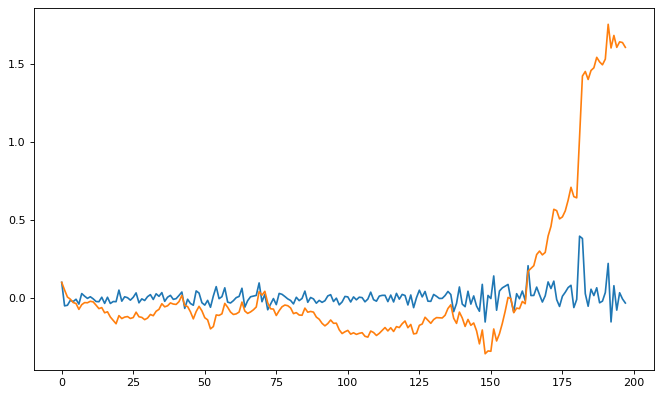

In [51]:
plt.figure(figsize=(10,6), dpi = 80)

cumulative = []
cumsum = 0
for i in plugInReturn:
    cumsum += i
    cumulative.append(cumsum)

plt.plot(plugInReturn)
plt.plot(cumulative)
#plt.plot(logRet['SPY'])


This is obviously so wildly outperforming the index so something is wrong with the code. My guess is that we get a massive jump in perfomance in what seems to be around the 2007 time period, and we have huge short positions in the portfolio that generate massive returns. Need to take a look at what's going wrong for the plug-in portfolio. 